<a href="https://colab.research.google.com/github/qweliant/DS-Unit-2-Applied-Modeling/blob/master/DS_Sprint_Challenge_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍔

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [1]:
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make all four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [3]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [4]:
train['DBA Name'].unique()

array(['TOM YUM RICE & NOODLE, INC.',
       'FILLING STATION  & CONVENIENCE  STORE', 'A P DELI', ...,
       'WALGREENS # 09438', 'EVERGREEN FOODMART',
       "JENI'S SPLENDID ICE CREAMS, LLC"], dtype=object)

In [5]:
train['AKA Name'].unique()

array(['TOM YUM CAFE', 'FILLING STATION  & CONVENIENCE  STORE',
       'A P DELI', ..., 'EVERGREEN FOODMART',
       "JENI'S SPLENDID ICE CREAMS, LLC", 'TAQUERIA CORAL, INC.'],
      dtype=object)

In [0]:
# train['Violations'].unique()


In [0]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [0]:
import numpy as np
def wrangle(X):  
    X = X.copy()

    X['Latitude'] = X['Latitude'].replace(-2e-08, 0)
    
    cols_with_zero = ['Longitude', 'Latitude']
    for col in cols_with_zero:
        X[col] = X[col].replace(0, np.nan)
            
    return X
train = wrangle(train)
test = wrangle(test)

In [8]:
import plotly.express as px
fig = px.scatter_mapbox(train, lon='Longitude', lat='Latitude', color='Risk', opacity=0.1)
fig.update_layout(mapbox_style='stamen-terrain')

In [9]:
train.dtypes

Inspection ID        int64
DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Violations          object
Latitude           float64
Longitude          float64
Location            object
Fail                 int64
dtype: object

In [10]:
train.Fail.value_counts()

0    29563
1    12102
Name: Fail, dtype: int64

In [11]:
train.Fail.value_counts(normalize=True)

0    0.70954
1    0.29046
Name: Fail, dtype: float64

# The map isn't as misleading as I would think. So I am comfortable saying most restaurants pass inspection with a baseline of 70 percent accuracy

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [0]:
from sklearn.model_selection import train_test_split

def train_validate(df, test_set):
    train_set, validation_set = train_test_split(df, test_size=len(test_set), stratify=train['Fail'], random_state=2121)
    return train_set, validation_set

train_set, validation_set = train_validate(train, test)

In [13]:
train_set.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
25567,533219,EL SOLAZO,EL SOLAZO,1840958.0,Restaurant,Risk 1 (High),5600 S PULASKI RD,CHICAGO,IL,60629.0,2011-02-14T00:00:00,Canvass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.791349,-87.723255,"{'longitude': '-87.72325532296887', 'latitude'...",0
21615,1199226,BINNY'S BEVERAGE DEPOT,BINNY'S BEVERAGE DEPOT,2279269.0,Grocery Store,Risk 3 (Low),1720-1780 N MARCEY ST,CHICAGO,IL,60614.0,2013-12-05T00:00:00,License,37. TOILET ROOM DOORS SELF CLOSING: DRESSING R...,41.913468,-87.655032,"{'longitude': '-87.65503220481568', 'latitude'...",0
46696,1493280,CITGO FUEL & MINI MART,FALCON FUEL,2084312.0,Grocery Store,Risk 3 (Low),8255-8259 S HALSTED ST,CHICAGO,IL,60620.0,2014-08-05T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.743565,-87.643690,"{'longitude': '-87.64368965493803', 'latitude'...",0
36304,1199562,STARBUCKS COFFEE #2877,STARBUCKS COFFEE #2877,1444270.0,Restaurant,Risk 2 (Medium),40 N CLINTON ST,CHICAGO,IL,60661.0,2014-10-16T00:00:00,Canvass,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.883108,-87.641377,"{'longitude': '-87.64137747810499', 'latitude'...",1
2126,1326503,LAZARO CARDENAS BRANCH,LAZARO CARDENAS BRANCH,24052.0,School,Risk 1 (High),2406 S Central Park (3600W),CHICAGO,IL,60623.0,2013-03-22T00:00:00,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.847771,-87.715034,"{'longitude': '-87.71503378052142', 'latitude'...",0


In [0]:
target = "Fail"
numbers_columns = train_set.select_dtypes(include='number').columns.drop([target, 'Inspection ID']).tolist()
categorical_columns = train_set.select_dtypes(exclude='number').columns.tolist()
drop_high_cardinality = [col for col in categorical_columns if train_set[col].nunique() <= 200]
features = numbers_columns + drop_high_cardinality

In [0]:
X_train = train_set[features]
y_train = train_set[target]
X_val = validation_set[features]
y_val = validation_set[target]
X_test = test[features]

In [25]:
y_train.value_counts(normalize=True)

0    0.70955
1    0.29045
Name: Fail, dtype: float64

In [26]:
y_val.value_counts(normalize=True)

0    0.709521
1    0.290479
Name: Fail, dtype: float64

In [0]:
import xgboost as xgb
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

In [33]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=1738, n_jobs=-1)
)

scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))
print('Validation ROC AUC:', scores)

Train Accuracy 0.9228890564953489
Validation Accuracy 0.7009115902184923
Validation ROC AUC: [0.65055621 0.6425256  0.64168055 0.64342259 0.65010518]


In [0]:
import matplotlib.pyplot as plt

model = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['ordinalencoder']



# I should assume I am doing something incorrect becasue the ROC AUC is not the 90% predicted. It does improve the baseline presictions by a couple precent howerver. I shooulod look at feature importance

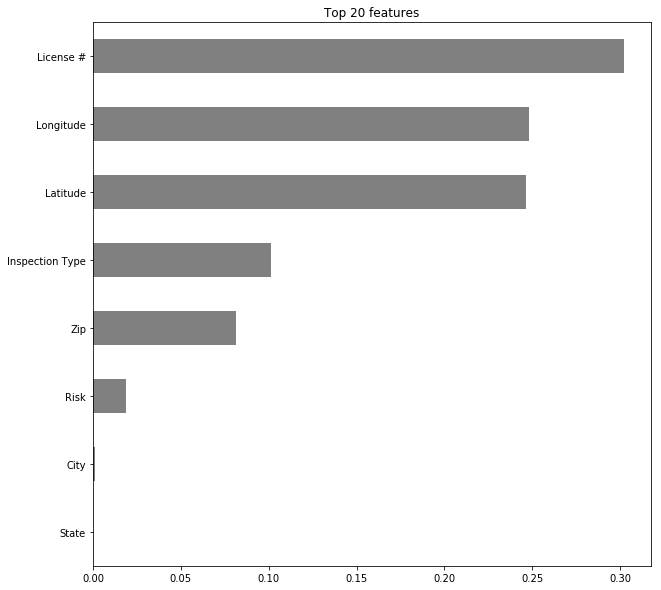

In [35]:
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

# I am not sure what Inspection ID is but eveything is cool so

Area under the Receiver Operating Characteristic curve: 0.6457020737703831


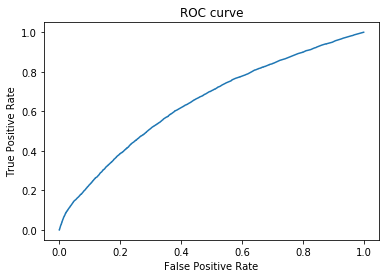

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_predict

y_pred_proba = cross_val_predict(pipeline, X_train, y_train, cv=5, n_jobs=-1,method='predict_proba')[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('Area under the Receiver Operating Characteristic curve:', 
      roc_auc_score(y_train, y_pred_proba))

# So the model trends towards giving false positives

## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

In [41]:
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.641925	validation_1-auc:0.640042
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.643191	validation_1-auc:0.641088
[2]	validation_0-auc:0.643538	validation_1-auc:0.6424
[3]	validation_0-auc:0.643526	validation_1-auc:0.642885
[4]	validation_0-auc:0.654297	validation_1-auc:0.650122
[5]	validation_0-auc:0.654471	validation_1-auc:0.649679
[6]	validation_0-auc:0.655615	validation_1-auc:0.650984
[7]	validation_0-auc:0.657258	validation_1-auc:0.650783
[8]	validation_0-auc:0.657149	validation_1-auc:0.65024
[9]	validation_0-auc:0.657575	validation_1-auc:0.649821
[10]	validation_0-auc:0.65772	validation_1-auc:0.649907
[11]	validation_0-auc:0.661168	validation_1-auc:0.653002
[12]	validation_0-auc:0.660821	validation_1-auc:0.652995
[13]	validation_0-auc:0.66683	validation_1-auc:0.658387
[14]	validation_0-auc:0.666911	validation_1-auc:0.658916
[15

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [44]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_val)
class_index = 1
y_pred_proba = model.predict_proba(X_val_processed)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_val, y_pred_proba)) # Ranges from 0-1, higher is better

Test ROC AUC for class 1:
0.6907667166855809


In [46]:
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)